In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

from quantipy.assets import Currency, Equity
from quantipy.trading import Broker, Strategy, TripleMovingAverage
from quantipy.backtest import Backtester
import quantipy.utils as _utils

%matplotlib inline
warnings.filterwarnings('ignore')

# backtest period
BACKTEST_START = '2016-01-01'
LIVE_START = '2019-01-01'

# trading universe
CAPITAL = 10_000
usd = Currency('USD')
spy = Equity('SPY', 'SPY')
ndq = Equity('NASDAQ', '^IXIC')
MKT = [spy, ndq]
BENCHMARK = 'SPY'

# strategy
STRATEGY = TripleMovingAverage([spy], {})

# strategy parameters

# PARAMS = {
#     'history1': [3, 4, 5, 6], 
#     'history2': [7, 9, 10, 12, 15],
#     'history3': [21, 24, 27, 30]
# }

PARAMS = {
    'history1': [4], 
    'history2': [15],
    'history3': [30]
}

# optimization metric defined as a function of the equity curve
def METRIC(equity):
    returns = _utils.compute_returns(equity)
    return _utils.sortino(returns)

In [2]:
# getting data
data = {}
for asset in MKT:
    ticker = yf.ticker.Ticker(asset.symbol)
    ticker_data = ticker.history(start=BACKTEST_START, end=LIVE_START,
                                 interval='1d')
    data[asset.symbol] = ticker_data

broker = Broker(data=data, initial_capital=CAPITAL, currency=usd)
backtester = Backtester(data)

opt_results = backtester.optimize(
    STRATEGY, broker, PARAMS, metric=METRIC, save_logs=False, benchmark=BENCHMARK
)

print(f"Optimal parameters: {opt_results['best_params']}")

Preparing optimization...
Starting optimization...
{'history1': 4, 'history2': 15, 'history3': 30}
Score: 0.3956754345753411
Optimal parameters: {'history1': 4, 'history2': 15, 'history3': 30}


Backtest Results
----------------------------------------
Metric           Strategy      Benchmark
----------------------------------------
Total Return:       5.64%         31.92%
Avg gain (day):     0.40%          0.51%
Avg loss (day):    -0.40%         -0.52%
Beta (BM):         0.3757              1
Sharpe Ratio:      0.2885         0.9572
Sortino Ratio:     0.3957         1.3215
----------------------------------------
Max Drawdown:     -11.26%        -19.35%
Avg Drawdown:      -4.38%         -2.16%
Avg DD Bars:           32              8
Longest DD:           426            131
----------------------------------------
Time in Market:    71.92%           100%
Trades:                29
Best Win:           7.27%
Avg Win:            2.55%
Worst Loss:        -3.36%
Avg Loss:          -1.42%
Win/Loss ratio:      0.71
Win %:             41.38%


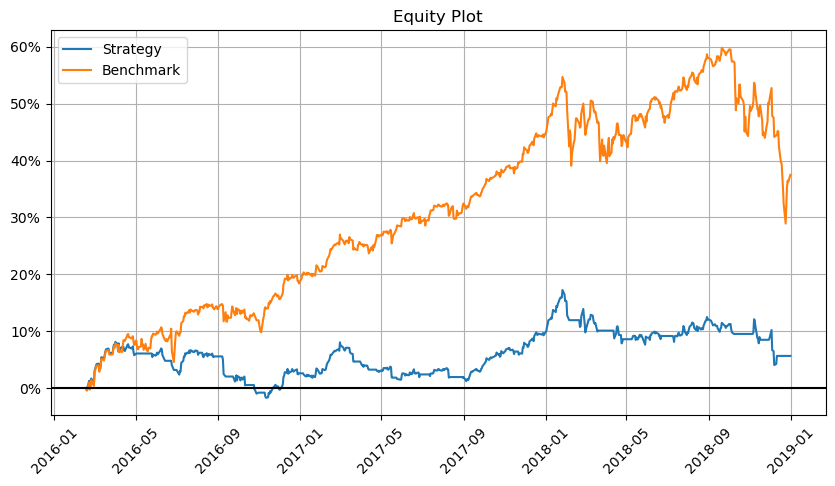

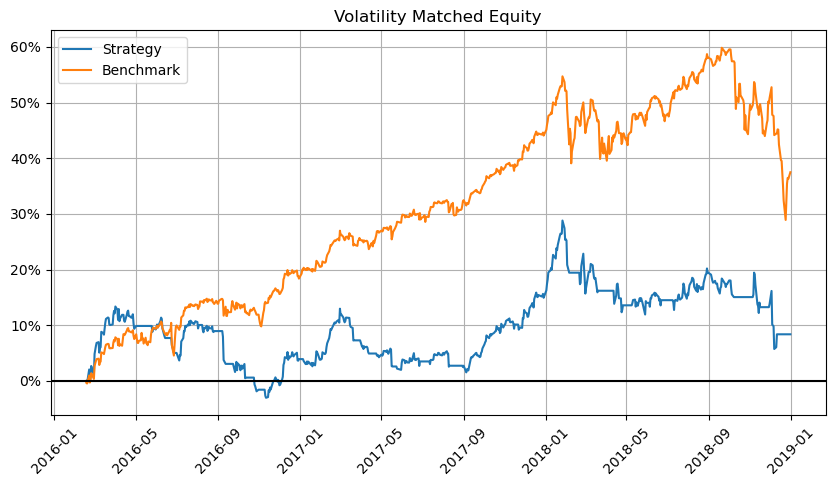

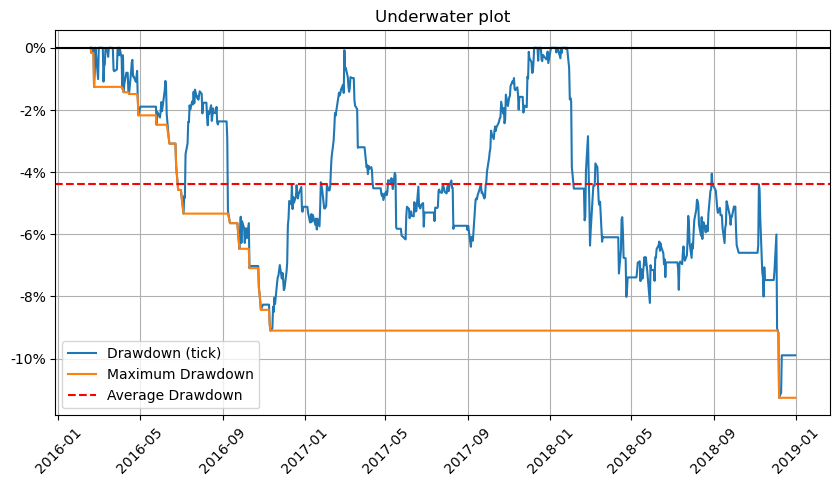

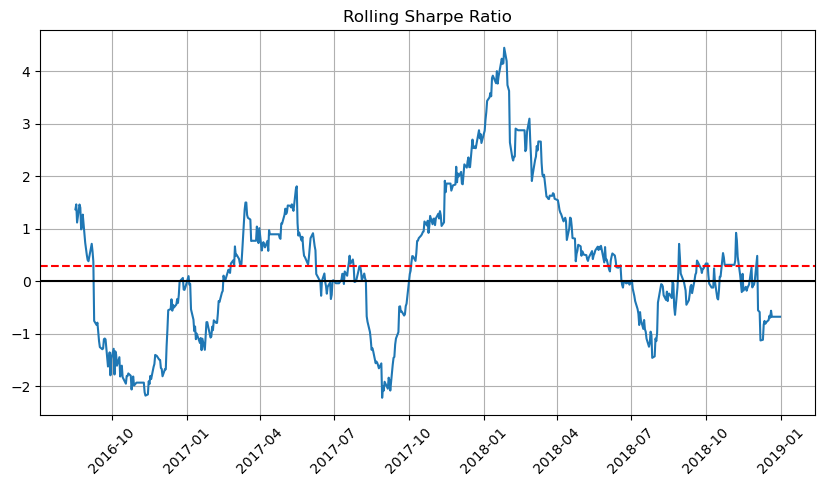

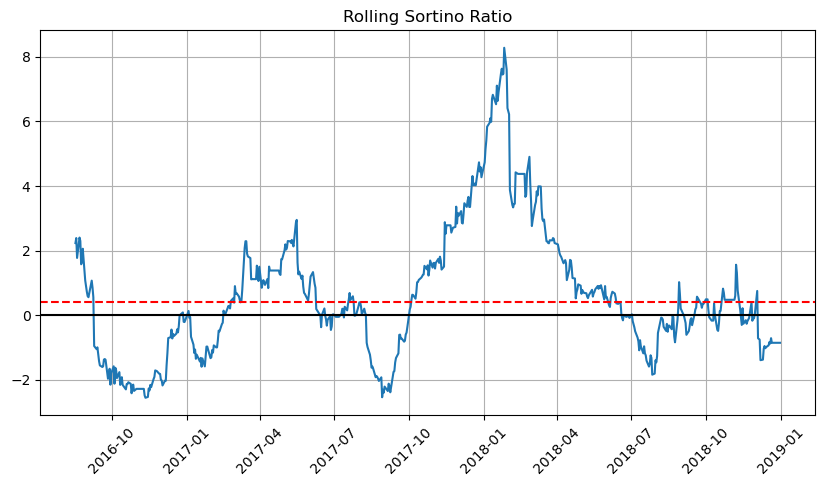

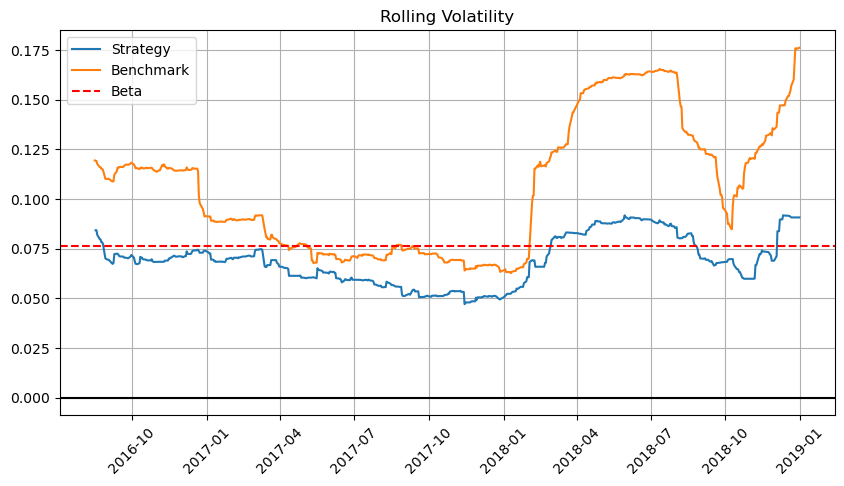

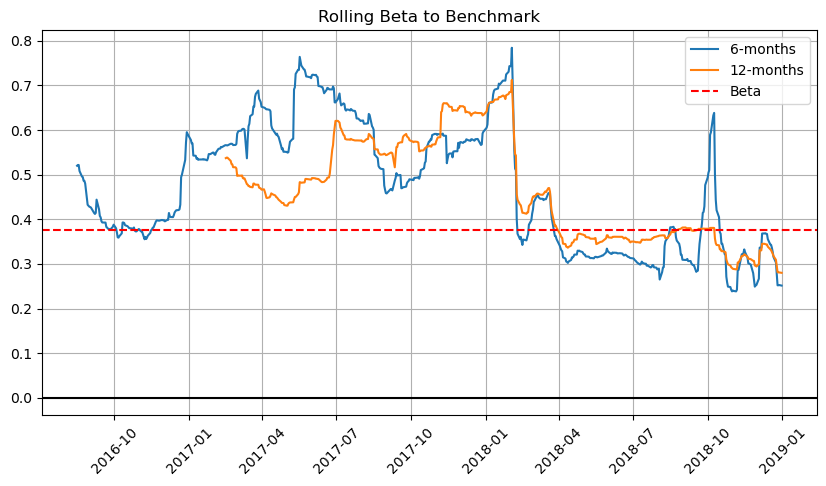

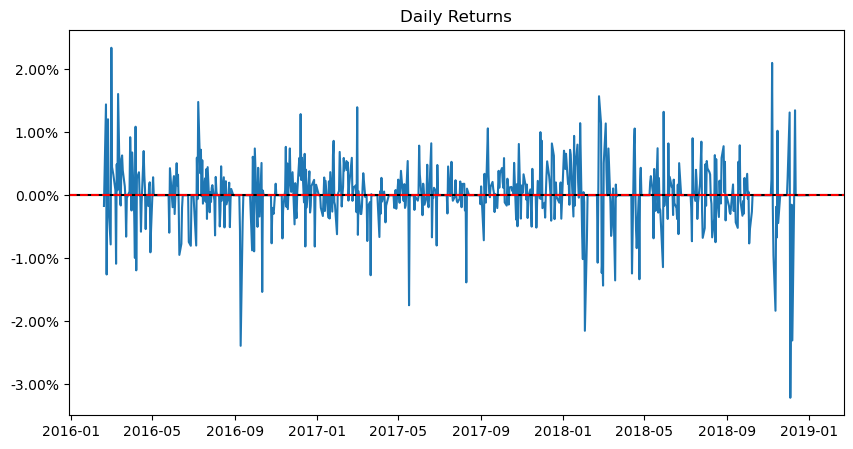

In [3]:
backtester.show_report()

In [4]:
# getting data
data = {}
for asset in MKT:
    ticker = yf.ticker.Ticker(asset.symbol)
    ticker_data = ticker.history(start=LIVE_START, interval='1d')
    data[asset.symbol] = ticker_data

STRATEGY.params = opt_results['best_params']

capital = opt_results['final_equity']

broker = Broker(data=data, initial_capital=CAPITAL, currency=usd)
live_backtester = Backtester(data)

live_backtest = live_backtester.run(STRATEGY, broker, save_logs=True)

Backtest Results
----------------------------------------
Metric           Strategy      Benchmark
----------------------------------------
Total Return:      81.89%        142.37%
Avg gain (day):     0.63%          0.83%
Avg loss (day):    -0.63%         -0.86%
Beta (BM):         0.3491              1
Sharpe Ratio:      0.9934         0.8272
Sortino Ratio:     1.4432         1.1570
----------------------------------------
Max Drawdown:     -14.39%        -33.72%
Avg Drawdown:      -3.91%         -5.75%
Avg DD Bars:           18             11
Longest DD:           548            488
----------------------------------------
Time in Market:    70.50%           100%
Trades:                45
Best Win:           9.55%
Avg Win:            3.89%
Worst Loss:        -7.11%
Avg Loss:          -2.27%
Win/Loss ratio:      1.50
Win %:             60.00%


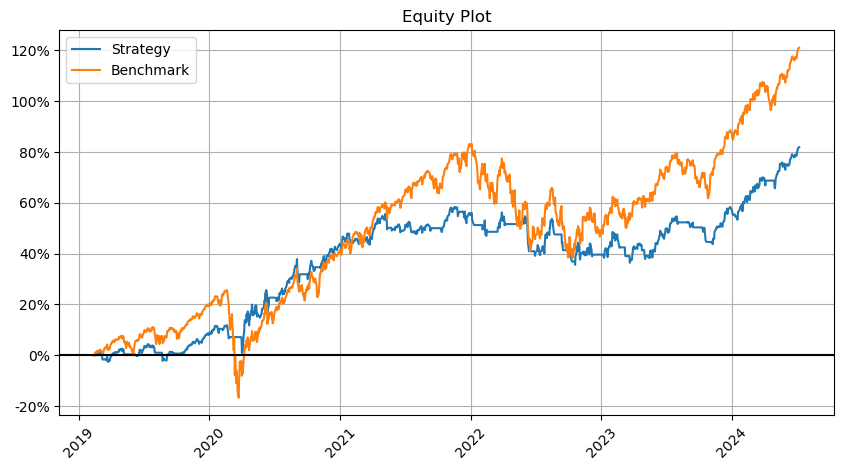

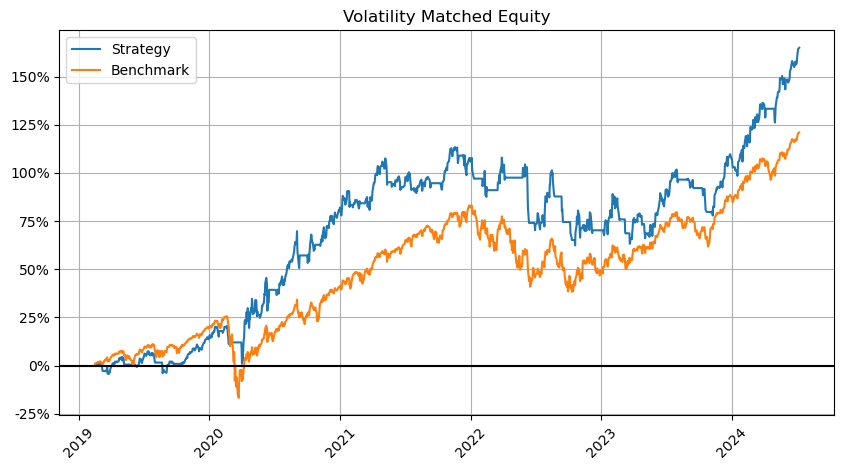

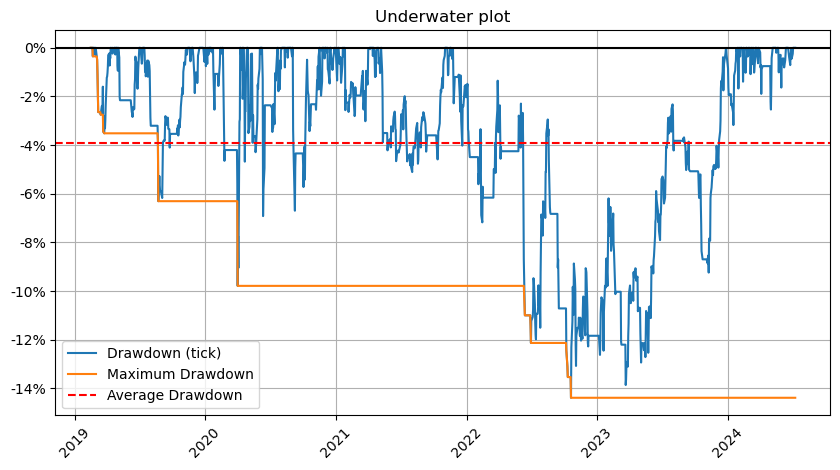

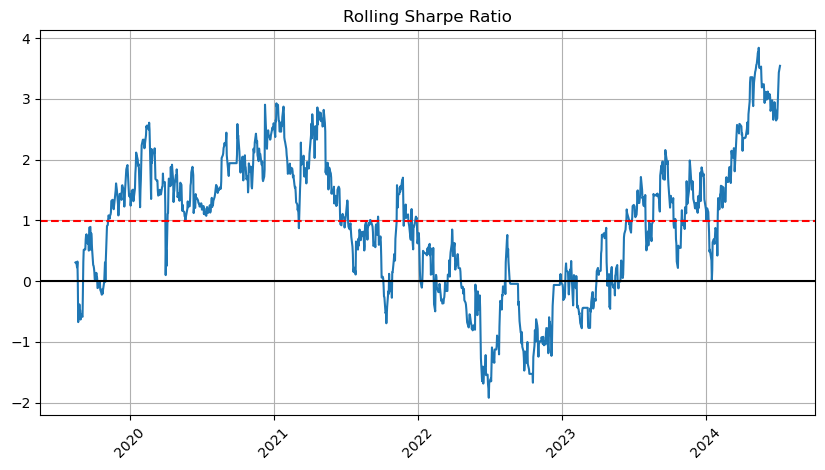

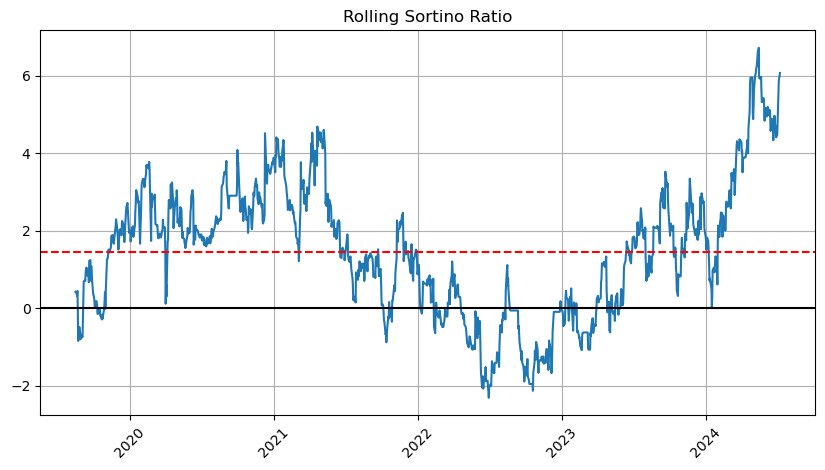

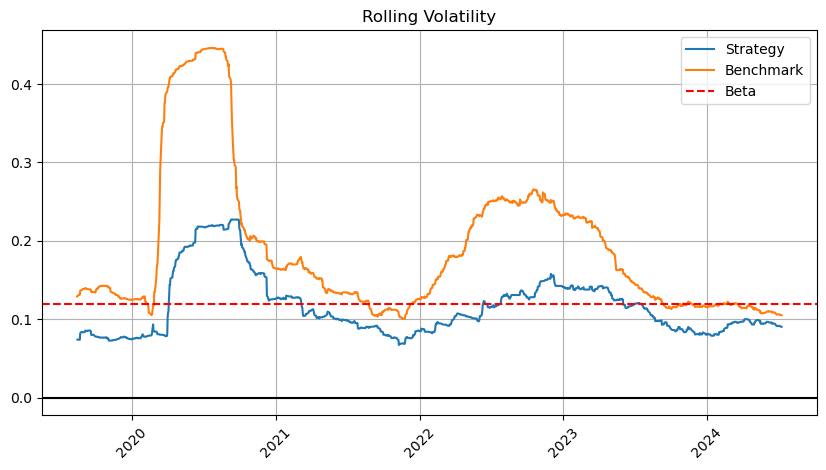

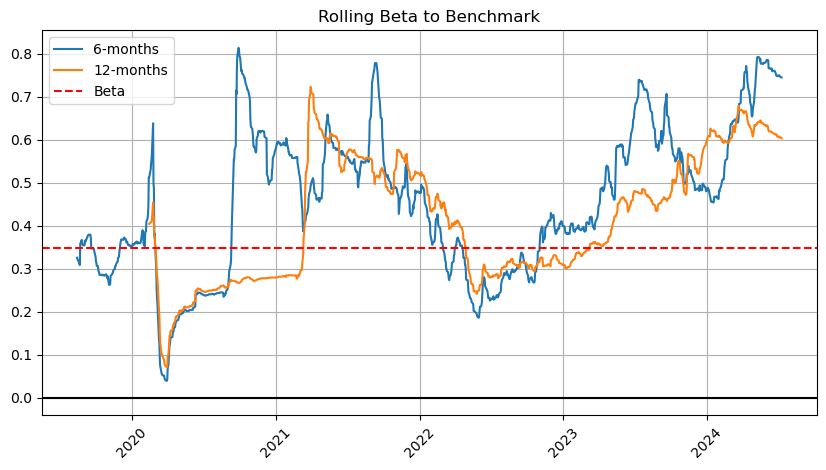

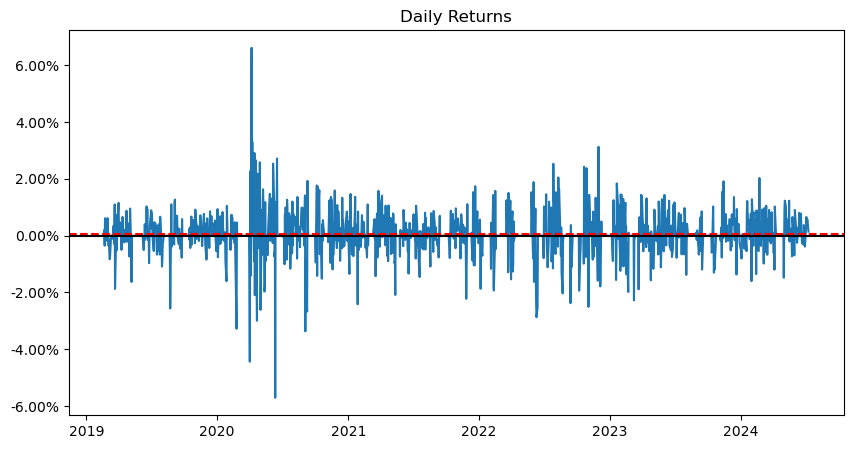

In [5]:
results = live_backtester.process_results(benchmark=BENCHMARK)
live_backtester.show_report()